In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tf_keras

In [3]:
!ls drive/MyDrive/Colab\ Notebooks/data-files
!mv drive/MyDrive/Colab\ Notebooks/data-files/dogs-vs-cats.zip sample_data/

dogs-vs-cats.zip


In [5]:
!unzip sample_data/dogs-vs-cats.zip

Archive:  sample_data/dogs-vs-cats.zip
   creating: dogs-vs-cats/
  inflating: __MACOSX/._dogs-vs-cats  
  inflating: dogs-vs-cats/.DS_Store  
  inflating: __MACOSX/dogs-vs-cats/._.DS_Store  
  inflating: dogs-vs-cats/test1.zip  
  inflating: __MACOSX/dogs-vs-cats/._test1.zip  
  inflating: dogs-vs-cats/train.zip  
  inflating: __MACOSX/dogs-vs-cats/._train.zip  


In [9]:
# !unzip sample_data/dogs-vs-cats/train.zip -d sample_data/dogs-vs-cats
# !unzip sample_data/dogs-vs-cats/test1.zip -d sample_data/dogs-vs-cats
# !mv sample_data/dogs-vs-cats/test1 sample_data/dogs-vs-cats/test
!rm -rf __MACOSX

In [ ]:
# 위 작업을 일괄 실행 (데이터 파일 압축해제)
!mv drive/MyDrive/Colab\ Notebooks/data-files/dogs-vs-cats.zip sample_data/
!unzip sample_data/dogs-vs-cats.zip -d sample_data
!unzip sample_data/dogs-vs-cats/train.zip -d sample_data/dogs-vs-cats
!unzip sample_data/dogs-vs-cats/test1.zip -d sample_data/dogs-vs-cats
!mv sample_data/dogs-vs-cats/test1 sample_data/dogs-vs-cats/test
!rm -rf sample_data/__MACOSX

In [26]:
# 데이터 디렉터리 구성
# train_dir, test_dir, validation_dir
# train_dir - dogs, cats
# test_dir - dogs, cats
# validation_dir - dogs, cats

import os
import shutil

src_base = 'sample_data/dogs-vs-cats'
dest_base = 'sample_data/dogs-vs-cats2'

if os.path.exists(dest_base):
  shutil.rmtree(dest_base) # train 경로 및 하위 경로 삭제
os.mkdir(dest_base)

# train 폴더의 0 ~ 1000 : train, 1000 ~ 1500 : validation, 1500 ~ 2000 : test 세트로 구성
for start, stop, path in zip([0, 1000, 1500], [1000, 1500, 2000], ['train', 'validation', 'test']):
  os.mkdir(os.path.join(dest_base, path))
  for sub_path in ['cat', 'dog']:
    os.mkdir(os.path.join(dest_base, path, sub_path))
    for idx in np.arange(start, stop):
      fname = f'{sub_path}.{idx}.jpg'
      shutil.copy(os.path.join(src_base, 'train', fname), os.path.join(dest_base, path, sub_path, fname))

In [27]:
for path in ['train', 'test', 'validation']:
  for sub_path in ['cat', 'dog']:
    print ( path, sub_path, ':', len(os.listdir(f'sample_data/dogs-vs-cats2/{path}/{sub_path}')) )

train cat : 1000
train dog : 1000
test cat : 500
test dog : 500
validation cat : 500
validation dog : 500


In [31]:
# 입력 자동화 도구 만들기 : 파일을 읽어서 모델에 입력 가능한 형식으로 변환하는 도구

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(rescale=1/255) # 특정 디렉터리의 파일을 읽어서 모델의 입력데이터로 변환하는 도구
validation_data_generator = ImageDataGenerator(rescale=1/255)
test_data_generator = ImageDataGenerator(rescale=1/255)

In [33]:
datasets = []
for path, generator in zip(['train', 'validation', 'test'],
                           [train_data_generator, validation_data_generator, test_data_generator]):
  dataset = generator.flow_from_directory(directory=f"sample_data/dogs-vs-cats2/{path}",
                                          target_size=(256, 256),
                                          batch_size=32,
                                          class_mode="binary")
  datasets.append(dataset)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [34]:
type( datasets[0] )

keras.src.preprocessing.image.DirectoryIterator

In [39]:
for X_batch, y_batch in datasets[0]:
  print(X_batch.shape, y_batch.shape)
  print(X_batch[0].max())
  print(y_batch)
  break

(32, 256, 256, 3) (32,)
1.0
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0.]


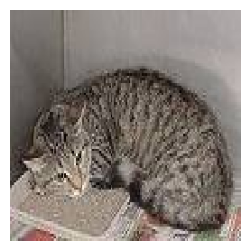

In [45]:
plt.figure(figsize=(3, 3))
plt.imshow(X_batch[0])
plt.axis('off')
plt.show()

In [46]:
# CNN 모델 훈련

model = tf_keras.Sequential([
    tf_keras.layers.Input(shape=(256, 256, 3)),
    tf_keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    tf_keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf_keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    tf_keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf_keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    tf_keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(units=512, activation='relu'),
    tf_keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
model.summary()
# tf_keras.utils.plot_model(model, show_shapes=True)

In [51]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [52]:
history = model.fit(datasets[0],
                    steps_per_epoch=100, epochs=20,
                    validation_data=datasets[1], validation_steps=50)

Epoch 1/20
  2/100 [..............................] - ETA: 8:44 - loss: 14.4266 - accuracy: 0.3281

KeyboardInterrupt: 